In [1]:
"""
Imports
"""
import sys
print(f"Python:\t{sys.version}")
import numpy as np
print(f"Numpy:\t\t{np.__version__}")
import tensorflow as tf
print(f"Tensorflow:\t{tf.__version__}")
import keras
print(f"Keras:\t\t{keras.__version__}")

import os
import matplotlib.pyplot as plt
from keras import Sequential
from keras import layers
from keras.applications import NASNetMobile # https://keras.io/api/applications/nasnet/#nasnetmobile-function

Python:	3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
Numpy:		1.23.3
Tensorflow:	2.10.0
Keras:		2.10.0


In [2]:
"""
Options
"""
model_name = "NasNet_70ftfl_60e_32b"

image_width = 128
image_height = 128
channels_dim = 3
classes_dim = 6
batch_size = 32

validation_split = 0.2
fine_tuning_frozen_layers = 0.7
base_learning_rate = 0.001
epochs_pretraining = 10
epochs_total = 60

shape = (image_height, image_width, channels_dim)

In [3]:
"""
Pathing
"""
SPECTROGRAMS_DIR = "../data/spectrograms/combined"
TF_MODELS_DIR = "../data/models_tf"
TFLITE_MODELS_DIR = "../data/models_tflite"

In [4]:
"""
Load data
"""
train = tf.keras.utils.image_dataset_from_directory(
    SPECTROGRAMS_DIR,
    validation_split=0.2,
    subset='training',
    image_size=(image_height, image_width),
    batch_size=batch_size,
    seed=123
)

valid = tf.keras.utils.image_dataset_from_directory(
    SPECTROGRAMS_DIR,
    validation_split=0.2,
    subset='validation',
    image_size=(image_height, image_width),
    batch_size=batch_size,
    seed=123
)

def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=classes_dim)
    return image, label

train = train.map(one_hot_encode)
valid = valid.map(one_hot_encode)



Found 29768 files belonging to 6 classes.
Using 23815 files for training.
Found 29768 files belonging to 6 classes.
Using 5953 files for validation.


In [6]:
"""
Build NasNet model
"""

tf.keras.backend.clear_session()

# Preprocessing
model_input = keras.Input(shape=(None, None, 3))
x = model_input
x = layers.Resizing(image_height, image_width)(x)
x = layers.Rescaling(1.0 / 255)(x)

# NasNet
nasnet = NASNetMobile(
    input_shape=shape,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=classes_dim,
    classifier_activation="softmax"
)

nasnet.trainable = False
x = nasnet(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.25)(x)
nasnet_output = layers.Dense(classes_dim, activation="softmax")(x)

nasnet_model = keras.Model(model_input, nasnet_output)
nasnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
nasnet_model.summary()

19993432/19993432 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 NASNet (Functional)         (None, 4, 4, 1056)        4269716   
                                                                 
 global_average_pooling2d (G  (None, 1056)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               135296 

Epoch 1/10
745/745 [==============================] - 94s 91ms/step - loss: 1.5014 - accuracy: 0.3834 - val_loss: 1.4187 - val_accuracy: 0.4315
Epoch 2/10
745/745 [==============================] - 60s 81ms/step - loss: 1.4146 - accuracy: 0.4253 - val_loss: 1.3938 - val_accuracy: 0.4379
Epoch 3/10
745/745 [==============================] - 60s 80ms/step - loss: 1.3773 - accuracy: 0.4459 - val_loss: 1.3728 - val_accuracy: 0.4500
Epoch 4/10
745/745 [==============================] - 60s 81ms/step - loss: 1.3536 - accuracy: 0.4531 - val_loss: 1.3597 - val_accuracy: 0.4547
Epoch 5/10
745/745 [==============================] - 60s 80ms/step - loss: 1.3284 - accuracy: 0.4640 - val_loss: 1.3458 - val_accuracy: 0.4618
Epoch 6/10
745/745 [==============================] - 59s 80ms/step - loss: 1.3063 - accuracy: 0.4771 - val_loss: 1.3390 - val_accuracy: 0.4653
Epoch 7/10
745/745 [==============================] - 60s 80ms/step - loss: 1.2858 - accuracy: 0.4845 - val_loss: 1.3317 - val_accuracy:

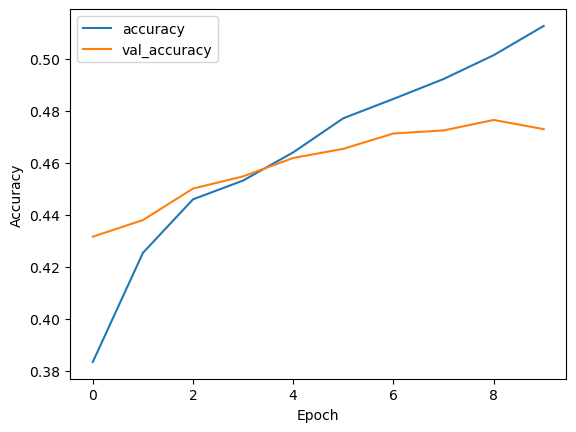

In [7]:
"""
Train model
"""

history_pretraining = nasnet_model.fit(train, validation_data=valid, epochs=epochs_pretraining)

plt.plot(history_pretraining.history['accuracy'], label='accuracy')
plt.plot(history_pretraining.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 NASNet (Functional)         (None, 4, 4, 1056)        4269716   
                                                                 
 global_average_pooling2d (G  (None, 1056)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               135296    
                                                             

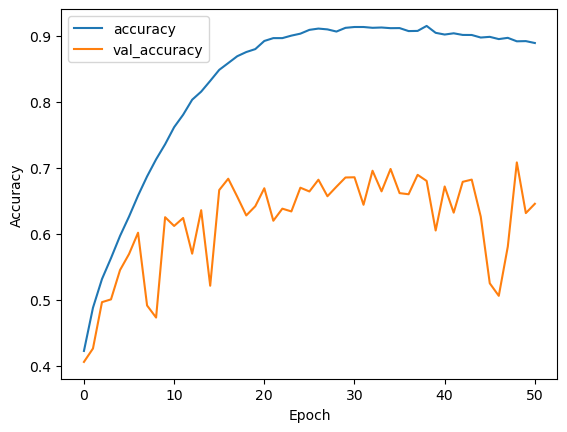

In [8]:
"""
Fine tuning
"""
nasnet.trainable = True
frozen_layers_amount = int(fine_tuning_frozen_layers * len(nasnet.layers))
for layer in nasnet.layers[:frozen_layers_amount]:
  layer.trainable = False
    
nasnet_model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=(base_learning_rate / 10)),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
nasnet_model.summary()
history_fine_tuning = nasnet_model.fit(train, validation_data=valid, epochs=epochs_total, initial_epoch=history_pretraining.epoch[-1])

plt.plot(history_fine_tuning.history["accuracy"], label="accuracy")
plt.plot(history_fine_tuning.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [9]:
"""
Save model
"""
nasnet_model.save(f"{TF_MODELS_DIR}/{model_name}")

INFO:tensorflow:Assets written to: ../data/models_tf/NasNet_70ftfl_60e_32b\assets


INFO:tensorflow:Assets written to: ../data/models_tf/NasNet_70ftfl_60e_32b\assets


In [11]:
"""
Convert SavedModel (TensorFlow) to .tflite
"""
converter = tf.lite.TFLiteConverter.from_saved_model(f"{TF_MODELS_DIR}/{model_name}")
tflite_model = converter.convert()

with open(f"{TFLITE_MODELS_DIR}/{model_name}.tflite", "wb") as f:
  f.write(tflite_model)